In [1]:
from temporal_fusion_transformer.src.datasets import ElectricityDataset
import temporal_fusion_transformer as tft

config = tft.Config.read_from_file("../temporal_fusion_transformer/configs/electricity.toml")
config

Using TensorFlow backend


{
    "batch_size": 8,
    "clipnorm": 0.0,
    "compression": "GZIP",
    "decay_alpha": 0.0,
    "decay_steps": 0.0,
    "drop_remainder": true,
    "dropout_rate": 0.1,
    "encoder_steps": 192,
    "epochs": 100,
    "hidden_layer_size": 160,
    "input_known_categorical_idx": [
        1,
        2,
        3,
        4
    ],
    "input_known_real_idx": [
        0
    ],
    "input_observed_idx": [],
    "input_static_idx": [
        0
    ],
    "known_categories_sizes": [
        12,
        31,
        24,
        7
    ],
    "learning_rate": 0.001,
    "num_attention_heads": 4,
    "num_decoder_blocks": 1,
    "num_outputs": 1,
    "quantiles": [
        0.1,
        0.5,
        0.9
    ],
    "shuffle_buffer_size": 1024,
    "split_overlap": 7,
    "static_categories_sizes": [
        370
    ],
    "test_boundary": "2014-09-01",
    "test_split_save_format": "parquet",
    "total_time_steps": 168,
    "unroll": true,
    "use_ema": false,
    "validation_boundary": "2014

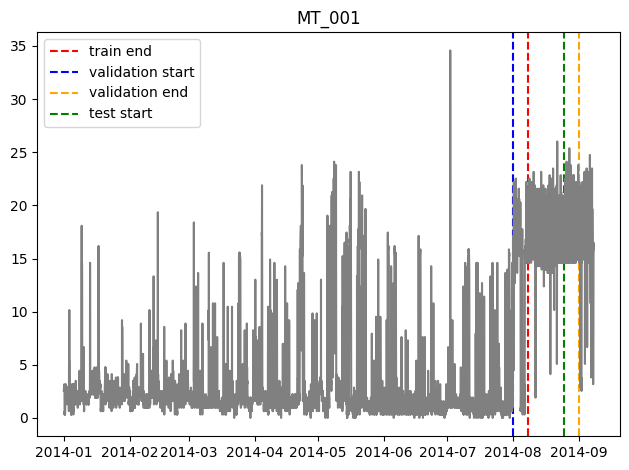

In [2]:
# MT_001 ... MT_370
ElectricityDataset(config).plot_dataset_splits("../data/electricity", "MT_001")